In [1]:
using MLDatasets
using PyPlot
using Random, Statistics
using Flux

# Rapid intro to supervised learning with neural nets I: from scratch

This notebook gives a rapid introduction to supervised learning with neural networks. The example is based on [Chapter 1 of Nielsen's online book "Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/chap1.html) and it guides you to set up the neural network training using the [Flux](https://fluxml.ai/Flux.jl/stable/) Julia package.

For further reading I recommend also the review article ["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823).

## A few words about Flux

[Flux](https://fluxml.ai/Flux.jl/stable/) provides functionality for deep learning that is similar to the established ML libraries [TensorFlow](https://www.tensorflow.org) and [PyTorch](https://pytorch.org). This means, in particular, automatic differentiation and simple ways to construct deep learning models (=neural networks).

### Automatic differentiation
With [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) we can let the computer compute gradients of arbitrary functions. In Flux the function `gradient()` takes a function and an input for the fuction as argument and the gradient of the given function. Example:

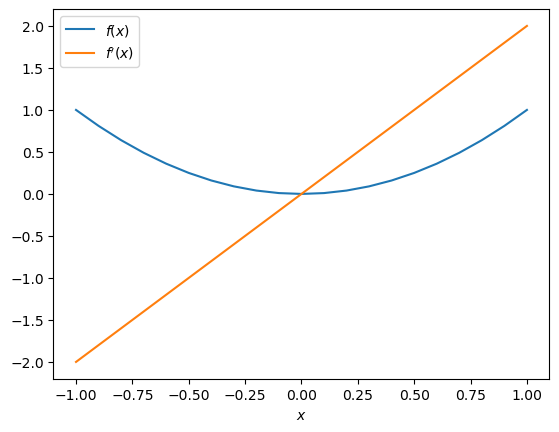

PyObject <matplotlib.legend.Legend object at 0x7fb17b24df40>

In [2]:
f(x)=x^2

f_prime(x)=Flux.gradient(f,x)[1]

x=-1.0:0.1:1.0
plot(x,f.(x),label=L"$f(x)$")
plot(x,f_prime.(x),label=L"$f'(x)$")
xlabel(L"$x$")
legend()

Notice: For the purpose of automatic differentiation Flux introduces *tracked* data types. Therefore, the plain `Flux.gradient(f,x)[1]` returns a tracked `Float` and we have to call the `Tracker.data` function in order to convert it into a plain `Float`.

## The MNIST hand-written digits data set

Let's first get a simple exemplary data set - the MNIST hand-written digits. The following cell downloads both the test and training parts of the data set.

In [3]:
# load full training set
train_x, train_y = float.(MNIST.traindata())
# load full test set
test_x,  test_y  = float.(MNIST.testdata());

`trainData` is now a array of shape `(28,28, 60000)`, meaning that we have 60k images of 28$\times$28 pixels (grayscale), each showing one hand-written digit. `trainLabels` holds the corresponding *labels*, i.e. an integer for each image, stating which digit it shows.

## Defining a neural network model using Flux

In [4]:
function build_model(layers; imgsize=(28,28))
    m = Dense(prod(imgsize), layers[1], sigmoid)
    for j in 2:length(layers)
        m = Chain(m, Dense(layers[j-1], layers[j],sigmoid))
    end
    return m
end

build_model (generic function with 1 method)

Now we can again what the network thinks about our images of digits. For this purpose we define `initialize_network` and `neural_network` analogous to part I of the tutorial, but this time based on our `MyNet` class.

In [5]:
net_layers=[100,10]

neural_network = build_model(net_layers)
params = Flux.params(neural_network) 

neural_network(reshape(train_x[:,:,1],28*28))

10-element Vector{Float32}:
 0.4186791
 0.38186157
 0.6507575
 0.5654196
 0.13589494
 0.53277546
 0.51723
 0.50953525
 0.49662584
 0.31771097

Next, we need a cost function. This is the same as in the previous notebook.

In [6]:
function cost_function(predictions, labels)
    """This function evaluates the cost function for given predictions and labels
    Args:
    * predictions: Predictions from neural net. Array of shape mathcal T x 10.
    * labels: Correct labels for the corresponding images. Array of mathcal T integers.
    Returns: Cost associated with the neural network predictions for the given data.
    """

    labels = Flux.onehotbatch(labels, 0:9)

    cost = sum((predictions-labels).^2)
    return cost / size(labels)[2]
end

cost_function (generic function with 1 method)

With this, we can check the performance of our randomly initialized network in classifying some of our images:

In [7]:
batch = train_x[:,:,1:128]    # select a batch of images
labels = train_y[1:128] # and corresponding labels

# ! compute neural network predictions
predictions = neural_network(reshape(batch, 28*28,size(batch)[3]))

# ! evaluate the cost function
cost_function(predictions,labels)

2.4402208f0

Now, what is missing is a function to compute the gradients of the cost function. This is easily solved using `Flux.gradient()` for automatic differentiation:

In [8]:
function cost_function_gradient(net, params, batch, labels)
    return Flux.gradient(() -> cost_function(net(reshape(batch, 28*28,size(batch)[3])),labels), params) 
end

cost_function_gradient (generic function with 1 method)

Finally, we are ready to train the network:

In [10]:
function evaluate_predictions(predictions, labels)
    """This is a helper function that counts how many of the given predictions match the labels.
    Args:
    * `predictions`: Predictions from neural network (=activations on output layer)
    * `labels`: correct labels
    Returns: Number of correct predictions, i.e., number of cases, in which the index of the maximal 
    activation matches the given label.
    """
    pred_labels = [Int(findmax(predictions[:,i])[2])-1 for i in 1:size(predictions)[2]]
        
    return sum(pred_labels .== labels)
end


prng_key = Random.seed!(1234)

neural_network = build_model(net_layers)
params = Flux.params(neural_network) 

# Here we define the hyperparamters
num_epochs = 10 # Number of epochs to loop over
learning_rate = 0.01 # Learning rate
batch_size = 128 # Size of mini-batches

# Compute the number of mini-batches that matches the chosen mini-batch size
batch_number = floor(Int,size(train_x)[end] / batch_size)

# Evaluate network and assess performance
predictions = neural_network(reshape(test_x,28*28,size(test_x)[3]))
current_cost = cost_function(predictions, test_y)
correct_predictions = evaluate_predictions(predictions, test_y)
println("Initial cost: $(current_cost)")
println("Correctly predicted labels: $(correct_predictions) / $(length(test_y))")

for n in 1:num_epochs
    
    println("Episode $(n)")
    order = shuffle(1:length(train_y))
    samples, labels = ( reshape(train_x[:,:,order][:,:,1:Int(batch_number*batch_size)], 28,28,128,:), 
        reshape(train_y[order][1:Int(batch_number*batch_size)], 128,:))

    
    for i in 1:batch_number

        # Compute gradients
        gs=cost_function_gradient(neural_network, params, samples[:,:,:,i], labels[:,i])
  
        # Perform SGD parameter update step
        for p in params
            Flux.Optimise.update!(p,learning_rate*gs[p])
        end
        
    end

    # Evaluate network and assess performance
    predictions = neural_network(reshape(test_x,28*28,size(test_x)[3]))
    current_cost = cost_function(predictions, test_y)    
    correct_predictions = evaluate_predictions(predictions, test_y)
    println("Current cost: $(current_cost)")
    println("Correctly predicted labels: $(correct_predictions)/$(length(test_y))")
end

Initial cost: 2.9444165
Correctly predicted labels: 1067 / 10000
Episode 1
Current cost: 0.86637384
Correctly predicted labels: 3561/10000
Episode 2
Current cost: 0.832702
Correctly predicted labels: 3970/10000
Episode 3
Current cost: 0.79138315
Correctly predicted labels: 4591/10000
Episode 4
Current cost: 0.74584115
Correctly predicted labels: 5070/10000
Episode 5
Current cost: 0.69996715
Correctly predicted labels: 5528/10000
Episode 6
Current cost: 0.656138
Correctly predicted labels: 6120/10000
Episode 7
Current cost: 0.61576265
Correctly predicted labels: 6510/10000
Episode 8
Current cost: 0.5789553
Correctly predicted labels: 7135/10000
Episode 9
Current cost: 0.5462902
Correctly predicted labels: 7458/10000
Episode 10
Current cost: 0.5175224
Correctly predicted labels: 7684/10000
